# CN


In [1]:
import pandas as pd

In [3]:
cn_score_source = pd.read_excel('sentiment_source/cn_train_data.xlsx')
cn_score_source.info(), cn_score_source.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7337 entries, 0 to 7336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7337 non-null   object
 1   score   7337 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 114.8+ KB


(None,
                                                 text  score
 0  苏州市物价局 您好您的来信收悉根据印发关于市区机动车停放服务收费改革意见的通知苏府号规定机动...      0
 1  触目惊心东北名男子街头上演武林风倒地男子被车碾死 月日凌晨时分大连市的太原街和同泰街交会出一...     -1
 2  以恋爱为名一女子诱骗网友到萍乡一传销窝点非法拘禁天 中国江西网讯徐政武见习记者薛柏武记者周再...     -1
 3  杭州芊颜化妆品有限公司被爆涉传老板很嚣张-浦口人网 杭州芊颜化妆品有限公司被爆涉传老板很嚣张...     -1
 4  蹊跷泰州一灵车停在屋里莫名起火把房子烧了麦泽利安的头颅-言 蹊跷泰州一灵车停在屋里莫名起火把...     -1)

### TF-IDF, Ridge/XGBoost

In [14]:
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import numpy as np

In [15]:
# Step 1: Chinese word segmentation
def tokenize(text):
    return " ".join(jieba.cut(text))

cn_score_source['text_tokenized'] = cn_score_source['text'].apply(tokenize)

# Step 2: TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(cn_score_source['text_tokenized'])
y = cn_score_source['score']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train Ridge regression
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Step 5: Train XGBoost regression
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Step 6: Evaluate both models
def evaluate(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

ridge_metrics = evaluate(y_test, y_pred_ridge)
xgb_metrics = evaluate(y_test, y_pred_xgb)

ridge_metrics, xgb_metrics

({'RMSE': 0.5069569343992312,
  'MAE': 0.3963599292140159,
  'R2': 0.3948572548864834},
 {'RMSE': 0.5174405119816862,
  'MAE': 0.42531049980135505,
  'R2': 0.36957046523674986})

### Chinese FinBert

### use scored sets as train set

In [ ]:
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

model_path = "FinBERT_L-12_H-768_A-12_pytorch"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)

cn_train_texts = cn_score_source["text"].astype(str).tolist()

# Extract [CLS] vectors as sentence vectors
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, 768)
    return cls_embedding.squeeze().numpy()

# Apply to all news, track process with tqdm
embeddings = [get_cls_embedding(text) for text in tqdm(cn_train_texts)]

embed_df = pd.DataFrame(embeddings)
embed_df["score"] = cn_score_source["score"].values
embed_df.to_csv("sentiment_source/cn_train_bert.csv", index=False)

100%|██████████| 7337/7337 [06:01<00:00, 20.32it/s]


In [ ]:
model_path = "FinBERT_L-12_H-768_A-12_pytorch"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertModel.from_pretrained(model_path)

cn_news_path = "data_final/cn_news.csv"
cn_news_df = pd.read_csv(cn_news_path)
cn_texts = cn_news_df["Headlines"].astype(str).tolist()

# Extract [CLS] vectors as sentence vectors
def get_cls_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: (1, 768)
    return cls_embedding.squeeze().numpy()

# Apply to all news, track process with tqdm
embeddings = [get_cls_embedding(text) for text in tqdm(cn_texts)]

embed_df = pd.DataFrame(embeddings)
embed_df.to_csv("data_final/cn_news_bert.csv", index=False)

100%|██████████| 3578/3578 [02:38<00:00, 22.60it/s]


In [ ]:
# Ridge, MLP, XGBoost for evaluation
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

df_train_bert = pd.read_csv("sentiment_source/cn_train_bert.csv")
X = df_train_bert.drop(columns=["score"])
y = df_train_bert["score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


models = {
    "Ridge": Ridge(),
    "MLP": MLPRegressor(hidden_layer_sizes=(512, 128), max_iter=300, random_state=42),
    "XGboost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
}

# Train, predict and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "MAE": mean_absolute_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    }

results


{'Ridge': {'RMSE': 0.4775876112290374,
  'MAE': 0.37125230181712104,
  'R2': 0.4629412456046471},
 'MLP': {'RMSE': 0.49274726626273363,
  'MAE': 0.364651839244405,
  'R2': 0.4283053313501518},
 'XGboost': {'RMSE': 0.4610354389982535,
  'MAE': 0.3459513115125476,
  'R2': 0.49952277909281206}}

Tuning Ridge...
Tuning MLP...
Tuning XGboost...
     Model                                        Best Params
0    Ridge                                   {'alpha': 100.0}
1      MLP  {'activation': 'tanh', 'hidden_layer_sizes': (...
2  XGboost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...


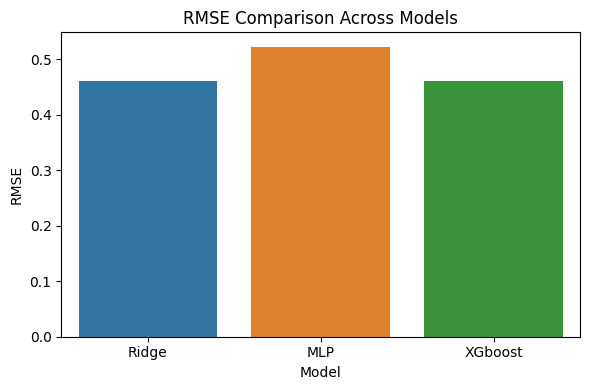

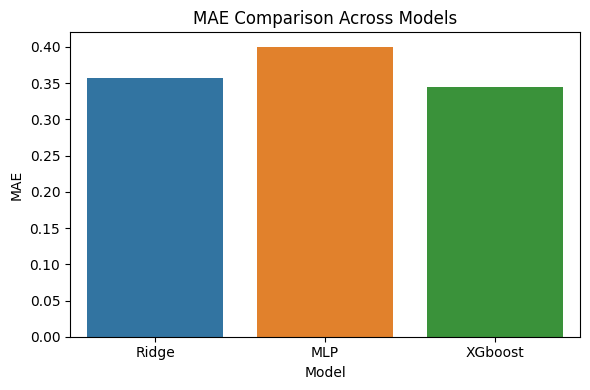

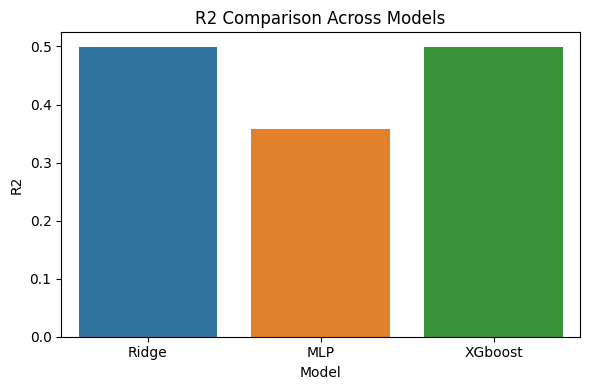

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import seaborn as sns

# Load and split data
df_train_bert = pd.read_csv("sentiment_source/cn_train_bert.csv")
X = df_train_bert.drop(columns=["score"])
y = df_train_bert["score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and hyperparameter grids
param_grids = {
    "Ridge": {
        "alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
    },
    "MLP": {
        "hidden_layer_sizes": [(128,), (256,)],
        "activation": ['relu', 'tanh'],
        "learning_rate_init": [0.001],
        "max_iter": [300]
    },
    "XGboost": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.1, 0.2]
    }
}

models = {
    "Ridge": Ridge(),
    "MLP": MLPRegressor(random_state=42),
    "XGboost": xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}

best_results = []

# Grid search + evaluation
for name in models:
    print(f"Tuning {name}...")
    grid = GridSearchCV(models[name], param_grids[name], scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    preds = best_model.predict(X_test)

    best_results.append({
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "MAE": mean_absolute_error(y_test, preds),
        "R2": r2_score(y_test, preds),
        "Best Params": grid.best_params_
    })

# Convert to DataFrame
results_df = pd.DataFrame(best_results)

# Save best params if needed
print(results_df[["Model", "Best Params"]])

# Plotting
metrics = ["RMSE", "MAE", "R2"]
for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.barplot(x="Model", y=metric, data=results_df)
    plt.title(f"{metric} Comparison Across Models")
    plt.ylabel(metric)
    plt.xlabel("Model")
    plt.tight_layout()
    plt.show()


In [5]:
# 显示完整列内容（避免截断）
pd.set_option('display.max_colwidth', None)

# 打印结果
print(results_df)



     Model      RMSE       MAE        R2  \
0    Ridge  0.461364  0.357078  0.498809   
1      MLP  0.522561  0.400216  0.357032   
2  XGboost  0.461110  0.344910  0.499362   

                                                                                          Best Params  
0                                                                                    {'alpha': 100.0}  
1  {'activation': 'tanh', 'hidden_layer_sizes': (256,), 'learning_rate_init': 0.001, 'max_iter': 300}  
2                                         {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}  


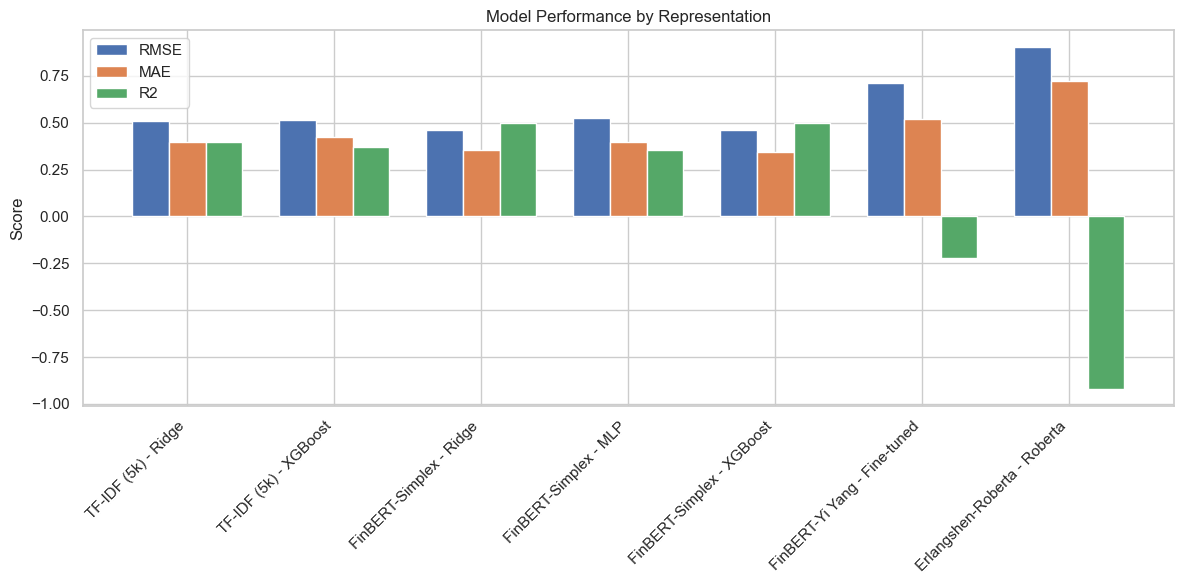

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define data
data = {
    "Representation": [
        "TF-IDF (5k)", "TF-IDF (5k)",
        "FinBERT-Simplex", "FinBERT-Simplex", "FinBERT-Simplex",
        "FinBERT-Yi Yang", "Erlangshen-Roberta"
    ],
    "Model": [
        "Ridge", "XGBoost",
        "Ridge", "MLP", "XGBoost",
        "Fine-tuned", "Roberta"
    ],
    "RMSE": [
        0.507, 0.517,
        0.461, 0.523, 0.461,
        0.713, 0.902
    ],
    "MAE": [
        0.396, 0.425,
        0.357, 0.400, 0.345,
        0.522, 0.722
    ],
    "R2": [
        0.395, 0.370,
        0.499, 0.357, 0.499,
        -0.221, -0.920
    ]
}

df = pd.DataFrame(data)

# Set up plot
metrics = ['RMSE', 'MAE', 'R2']
x_labels = df['Representation'] + ' - ' + df['Model']
x = np.arange(len(x_labels))  # label locations
width = 0.25

# Create grouped bar plot
fig, ax = plt.subplots(figsize=(12, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width - width, df[metric], width, label=metric)

# Aesthetics
ax.set_ylabel('Score')
ax.set_title('Model Performance by Representation')
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.grid(True, axis='y')

plt.show()


### choose XGBoost

In [ ]:
cn_news_bert = pd.read_csv("data_final/cn_news_bert.csv")
cn_news = pd.read_csv("data_final/cn_news.csv")

X_train = df_train_bert.drop(columns=["score"])
y_train = df_train_bert["score"]

# Fit XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predict sentiment scores on financial news
xgb_scores = xgb_model.predict(cn_news_bert)

# Normalize the scores to [-1, 1]
min_score, max_score = xgb_scores.min(), xgb_scores.max()
xgb_scores_norm = 2 * (xgb_scores - min_score) / (max_score - min_score) - 1 if max_score != min_score else np.zeros_like(xgb_scores)

# Combine with date and headlines
cn_news["score"] = xgb_scores_norm
cn_news

,Unnamed: 0,Headlines,time,score
0,0,【2018年基金展望：公募弱冠重构江湖 私募借势探路国际】2018年是贯彻党的十九大精神的开...,2018-01-01,0.336547
1,1,【2017年基金排名新鲜出炉 价值投资者尽享“王者盛宴”】随着2017年最后一个交易日结束，...,2018-01-01,0.363028
2,2,【全年PMI增长平稳 中国经济换挡进入新阶段】近日，国家统计局服务业调查中心和中国物流与采购...,2018-01-01,0.356259
3,3,【四部委：新能源车免征购置税延至2020年】12月27日，财政部等四部委发布公告称，财政部、...,2018-01-01,0.002112
4,4,【新华社：2018年A股“高歌”开门红 资本市场发展新年将“更上层楼”】2018年第一个交易...,2018-01-02,0.468627
...,...,...,...,...
3573,3573,【中国人民银行行长易纲新年致辞】 原图,2019-12-31,0.091625
3574,3574,【人民银行行长易纲看望慰问外汇储备经营管理人员】网页链接,2019-12-31,-0.092145
3575,3575,【北向资金连续30日净流入 科技和医药股是今年两条增持主线】2019年是外资快速涌入A股市场...,2019-12-31,0.283359
3576,3576,【隔夜外盘】欧美股市普跌，道指跌超180点，纳指跌0.67%，失守9000点整数关口；蔚来收...,2019-12-31,-0.249491


In [ ]:
cn_news = cn_news.drop(columns = ['Unnamed: 0'])
cn_news.to_csv("data_scored/cn_news_scored.csv", encoding='utf-8-sig')

### Erlangshen Sentiment

In [32]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment")
model = AutoModelForSequenceClassification.from_pretrained("IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment")
model.eval()

df = pd.read_csv("data_final/cn_news.csv")
texts = df["Headlines"].astype(str).tolist()


/Users/janedoe/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [33]:
def get_sentiment_score(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.softmax(outputs.logits.squeeze(), dim=0)
    score = probs[1] - probs[0] 
    return score.item()

scores = []
for text in tqdm(texts, desc="Scoring Sentiment"):
    score = get_sentiment_score(text)
    scores.append(score)


df["sentiment_score"] = scores
df

Scoring Sentiment: 100%|██████████| 3578/3578 [03:14<00:00, 18.39it/s]


,Unnamed: 0,Headlines,time,sentiment_score
0,0,【2018年基金展望：公募弱冠重构江湖 私募借势探路国际】2018年是贯彻党的十九大精神的开...,2018-01-01,0.877919
1,1,【2017年基金排名新鲜出炉 价值投资者尽享“王者盛宴”】随着2017年最后一个交易日结束，...,2018-01-01,0.979904
2,2,【全年PMI增长平稳 中国经济换挡进入新阶段】近日，国家统计局服务业调查中心和中国物流与采购...,2018-01-01,0.988800
3,3,【四部委：新能源车免征购置税延至2020年】12月27日，财政部等四部委发布公告称，财政部、...,2018-01-01,0.966047
4,4,【新华社：2018年A股“高歌”开门红 资本市场发展新年将“更上层楼”】2018年第一个交易...,2018-01-02,0.966014
...,...,...,...,...
3573,3573,【中国人民银行行长易纲新年致辞】 原图,2019-12-31,0.911796
3574,3574,【人民银行行长易纲看望慰问外汇储备经营管理人员】网页链接,2019-12-31,0.912329
3575,3575,【北向资金连续30日净流入 科技和医药股是今年两条增持主线】2019年是外资快速涌入A股市场...,2019-12-31,0.994904
3576,3576,【隔夜外盘】欧美股市普跌，道指跌超180点，纳指跌0.67%，失守9000点整数关口；蔚来收...,2019-12-31,0.805653


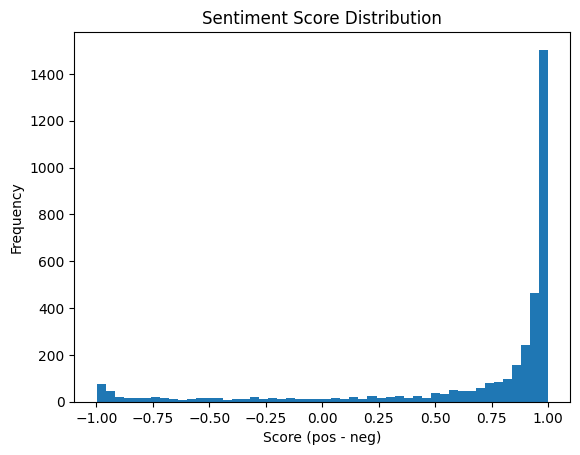

In [34]:
import matplotlib.pyplot as plt

plt.hist(df["sentiment_score"], bins=50)
plt.title("Sentiment Score Distribution")
plt.xlabel("Score (pos - neg)")
plt.ylabel("Frequency")
plt.show()

In [35]:
print("Total samples:", len(df))
print("Score > 0.8:", (df["sentiment_score"] > 0.8).sum())
print("Score < -0.2:", (df["sentiment_score"] < -0.2).sum())


Total samples: 3578
Score > 0.8: 2464
Score < -0.2: 391


In [5]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ----------------------------------------------------------------------
# 1. Load 20 % sample of the labelled data
# ----------------------------------------------------------------------
df_full = pd.read_excel("sentiment_source/cn_train_data.xlsx")
TEXT_COL, TARGET_COL = "text", "score"

df = df_full.sample(frac=0.20, random_state=42).reset_index(drop=True)  # 20 % subsample
texts = df[TEXT_COL].tolist()

# ----------------------------------------------------------------------
# 2. Model & tokenizer
# ----------------------------------------------------------------------
tok = AutoTokenizer.from_pretrained("IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment")
model = AutoModelForSequenceClassification.from_pretrained(
    "IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment"
).eval()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# ----------------------------------------------------------------------
# 3. Batched inference
# ----------------------------------------------------------------------
BATCH = 64        # adjust to your GPU/CPU memory
MAXLEN = 128

pred_scores = []
for i in tqdm(range(0, len(texts), BATCH), desc="Scoring 20 % sample"):
    batch_texts = texts[i : i + BATCH]
    enc = tok(batch_texts,
              return_tensors="pt",
              padding=True,
              truncation=True,
              max_length=MAXLEN).to(device)

    with torch.no_grad():
        logits = model(**enc).logits           # shape: [B, 2]  (neg, pos)

    probs = torch.softmax(logits, dim=1).cpu()
    # score = P(pos) – P(neg)
    batch_scores = (probs[:, 1] - probs[:, 0]).tolist()
    pred_scores.extend(batch_scores)

df["pred_score"] = pred_scores

# ----------------------------------------------------------------------
# 4. Metrics
# ----------------------------------------------------------------------
y_true = df[TARGET_COL].values
y_pred = df["pred_score"].values

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f" MAE: {mae:.4f}")
print(f"  R²: {r2:.4f}")

# optional: save the evaluated subset
# df.to_excel("erlangshen_20pct_scored.xlsx", index=False)


/Users/janedoe/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Scoring 20 % sample:   0%|          | 0/23 [00:00<?, ?it/s]

RMSE: 0.9021
 MAE: 0.7223
  R²: -0.9196


/Users/janedoe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Chinese Finbert

In [ ]:
import pandas as pd
from transformers import (AutoModelForSequenceClassification,
                          BertTokenizerFast, TextClassificationPipeline)
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm.auto import tqdm

# ==== 1. 配置 ==========================================================
DATA_PATH   = "sentiment_source/cn_train_data.xlsx"
TEXT_COL    = "text"     
TARGET_COL  = "score"   
BATCH_SIZE = 32

# ==== 2. 读数据 ========================================================
df = pd.read_excel(DATA_PATH)

# ==== 3. 初始化管道 ====================================================
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone-chinese")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone-chinese")
pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=-1,          # -1=CPU；如果用GPU改成0
    batch_size=32,
    truncation=True,
    max_length=256
)



/Users/janedoe/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

/Users/janedoe/anaconda3/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Scoring:   0%|          | 0/230 [00:00<?, ?it/s]

StopIteration: 

In [3]:

# ==== 4. 批量推理得到 p(pos)−p(neg) ===================================
def score_one(pred_list):
    label_dict = {d["label"]: d["score"] for d in pred_list}
    p_pos = label_dict.get("Positive", 0.0)
    p_neg = label_dict.get("Negative", 0.0)
    return p_pos - p_neg

# 用分块方式避免一次性占太多显存/内存
pred_scores = []
for start in tqdm(range(0, len(df), BATCH_SIZE), desc="Scoring"):
    end = start + BATCH_SIZE
    batch_text = df.loc[start:end-1, TEXT_COL].tolist()
    batch_out  = pipe(batch_text)
    pred_scores.extend([score_one(r) for r in batch_out])

df["pred_score"] = pred_scores

# ==== 5. 评估 ==========================================================
y_true = df[TARGET_COL]
y_pred = df["pred_score"]

rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f" MAE: {mae:.4f}")
print(f"  R²: {r2:.4f}")

Scoring:   0%|          | 0/230 [00:00<?, ?it/s]

RMSE: 0.7125
 MAE: 0.5220
  R²: -0.2208


/Users/janedoe/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### translate to english then score


In [10]:
cn_scored = pd.read_csv("data_final/cn_news_to_en.csv")

cn_news_to_en = pd.read_csv("data_final/cn_news_to_en.csv")
cn_news_to_en

,time,Headlines
0,2018-01-01,[2018 Fund Outlook: Public offerings restructu...
1,2018-01-01,"[2017 fund rankings are freshly released, valu..."
2,2018-01-01,"[PMI growth throughout the year is stable, Chi..."
3,2018-01-01,[Four ministries and commissions: The exemptio...
4,2018-01-02,"[Xinhua News Agency: A-shares ""sing"" in 2018 h..."
...,...,...
3573,2019-12-31,[New Year's Speech by the Governor of the Peop...
3574,2019-12-31,[People's Bank Governor Yi Gang visited and co...
3575,2019-12-31,[Northern capital inflows for 30 consecutive d...
3576,2019-12-31,[Overnight foreign market] European and Americ...


In [11]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm

# Load FinBERT model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model.eval()

texts = cn_news_to_en["Headlines"].astype(str).tolist()

# Label map
label_map = {0: "negative", 1: "neutral", 2: "positive"}

# Inference function
def predict_sentiment(texts, batch_size=32):
    sentiments = []
    scores = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=-1)
        labels = torch.argmax(probs, dim=1).tolist()
        sentiments.extend([label_map[label] for label in labels])
        scores.extend(probs.tolist())

    return sentiments, scores

# Run
sentiments, scores = predict_sentiment(texts)

# Save results
cn_news_to_en["finbert_sentiment"] = sentiments
cn_news_to_en["finbert_pos_score"] = [s[2] for s in scores]
cn_news_to_en["finbert_neu_score"] = [s[1] for s in scores]
cn_news_to_en["finbert_neg_score"] = [s[0] for s in scores]


/Users/janedoe/anaconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 112/112 [01:28<00:00,  1.27it/s]


In [12]:
from sklearn.preprocessing import MinMaxScaler

cn_news_to_en["finbert_sentiment_score"] = (
    cn_news_to_en["finbert_pos_score"] - cn_news_to_en["finbert_neg_score"]
)

scaler = MinMaxScaler(feature_range=(-1, 1))
cn_news_to_en["score"] = scaler.fit_transform(
    cn_news_to_en[["finbert_sentiment_score"]]
)

cn_news_to_en = cn_news_to_en.drop(columns = ['finbert_sentiment', 'finbert_pos_score', 'finbert_neu_score', 'finbert_neg_score', 'finbert_sentiment_score'])
cn_news_to_en

,time,Headlines,score
0,2018-01-01,[2018 Fund Outlook: Public offerings restructu...,0.700638
1,2018-01-01,"[2017 fund rankings are freshly released, valu...",0.869158
2,2018-01-01,"[PMI growth throughout the year is stable, Chi...",-0.957210
3,2018-01-01,[Four ministries and commissions: The exemptio...,0.839678
4,2018-01-02,"[Xinhua News Agency: A-shares ""sing"" in 2018 h...",-0.948129
...,...,...,...
3573,2019-12-31,[New Year's Speech by the Governor of the Peop...,0.973275
3574,2019-12-31,[People's Bank Governor Yi Gang visited and co...,0.867485
3575,2019-12-31,[Northern capital inflows for 30 consecutive d...,-0.921750
3576,2019-12-31,[Overnight foreign market] European and Americ...,0.009291


In [13]:
cn_news_to_en.to_csv("data_scored/cn_to_en_scored.csv", index=False)